<a href="https://colab.research.google.com/github/yosbel-penate/AppEFThreading/blob/master/T2V_LSTM_KalmanFilter_2021_Commentary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pykalman mlflow

     |████████████████████████████████| 228 kB 13.3 MB/s 
     |████████████████████████████████| 15.5 MB 67.5 MB/s 
     |████████████████████████████████| 596 kB 78.7 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 77.6 MB/s 
     |████████████████████████████████| 180 kB 64.9 MB/s 
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 146 kB 75.9 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=d05f6476bc4feb3797bbc21fe41057216eb11a066bc094521579eff0eff8b050
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158172 sha256=a94c7b2e2366effed7

Importar las librerias necesarias.

*   Pandas: En Computación y Ciencia de datos, Pandas es una biblioteca de software escrita como extensión de NumPy para manipulación y análisis de datos para el lenguaje de programación Python. En particular, ofrece estructuras de datos y operaciones para manipular tablas numéricas y series temporales.
*   The sklearn. metrics module implements several loss, score, and utility functions to measure classification performance. Some metrics might require probability estimates of the positive class, confidence values, or binary decisions values.


*   TensorFlow es una biblioteca de código abierto para aprendizaje automático a través de un rango de tareas, y desarrollado por Google para satisfacer sus necesidades de sistemas capaces de construir y entrenar redes neuronales para detectar y descifrar patrones y correlaciones, análogos al aprendizaje y razonamiento usados por los humanos.1​ 
*   MLflow es una plataforma de código abierto para administrar el ciclo de vida completo del aprendizaje automático. Proyectos: Permiten empaquetar el código de Machine Learning en una forma reutilizable y reproducible para compartirlo con otros científicos de datos o transferirlos a producción.
*  Pykalman Libreria en python que implementa el filtro Kalman.

In [3]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error

from typing import Tuple, Dict

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

import os

from mlflow import log_metric, log_param, log_artifacts

import warnings
warnings.filterwarnings("ignore")

from pykalman import KalmanFilter

En esta seccion que guardan los parametros del modelo y los datos que seran usados en MLFlow. CRIPTO es el nombre del par de la criptomoneda que se va a utilizar, VELAS es el periodo de actualizacion del con que ha sido construido el dataset. Con log_param() se van a crear los parametros de la libreria MLFlow. El diccionario 'param' almacena los parametros a utilizar en el modelo.

In [4]:
CRIPTO = 'ADAEUR'
VELAS = '15m'
log_param("moneda", CRIPTO)
log_param("velas", VELAS)

SEQUENCE_LENGHT = 100

param = {
    'unit': 50,
    't2v_dim': 50,
    'lr': 1e-2, 
    'act': 'relu', 
    'epochs': 10,
    'batch_size': 100
}


Se monta la unidad de Driver don de esta guardado el Dataset, en este caso es colab permite mediante la libreria de google acceder a google drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se define el direcctorio dentro de la unidad de google driver y el nombre del dataset que esta en formato csv.

In [6]:
dir='/content/drive/MyDrive/Maestria 2 año 1 semestre/Инструментальные платформы прогнозной аналитики (Куляница Андрей Леонидович)/'
dataSetFile='2021.csv'
df = pd.read_csv(dir+dataSetFile)

In [7]:
df.shape

(500, 8)

In [8]:
df.head()

,Unnamed: 0,time,open,high,low,close,volume,date
0,0,1.637779e+12,1.629,1.631,1.615,1.615,1926807.4,1975-03-11 13:51:00
1,1,1.637780e+12,1.616,1.618,1.611,1.615,2393867.9,1975-03-11 13:52:30
2,2,1.637780e+12,1.614,1.618,1.601,1.605,3254583.7,1975-03-11 13:54:00
3,3,1.637781e+12,1.605,1.614,1.604,1.607,2101630.6,1975-03-11 13:55:30
4,4,1.637782e+12,1.607,1.620,1.606,1.618,1992281.9,1975-03-11 13:57:00


Esta grafica se muestra el comportamiento de los precios de cierre en este intervalo de tiempo.

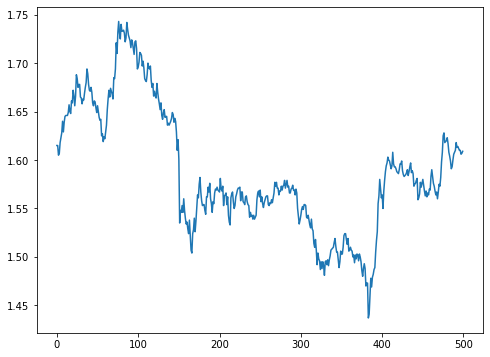

In [9]:
df['close'].plot(figsize=(8,6))

Se define la funcion de Kalma, la cual basicamente se utiliza para quitar ruedo de la grafica de cierres, que lo que interesa es la tendencia del mercado y no las oscilaciones exactas que tiene la grafica de precios.

In [10]:

def KalmanTransform(df: pd.DataFrame,variable: str = 'close') -> None:
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean =df['{}'.format(variable)].values.mean(),
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.05)
    state_means, _ = kf.filter(df[variable].values)
    df['kalman'] = pd.Series(state_means.flatten(), index=df.index)

Se repite la funcion anterior para graficar el resultado de aplicar Kalman a set de datos de los precios de cierre

In [11]:
df_tmp=df.copy()

kf = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean =df_tmp['close'].values.mean(),
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=.05)
state_means, _ = kf.filter(df_tmp['close'].values)
df_tmp['kalman'] = pd.Series(state_means.flatten(), index=df.index)

Se grafican ambas funciones, la funcion original que esta en azul, y el resultado de aplicar el filtro kalman, como se puede observar, se obtiene una linea suavizada que representa la tendencia aproximanda de la grafica, es como si se hubiera eliminado el movimiento aleatrorio de las variaciones de precio, y obtenemos la tendencia general del mercado.

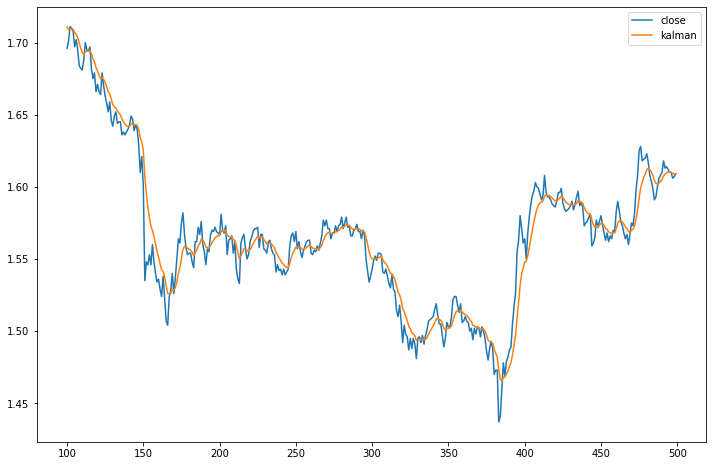

In [12]:
df_tmp[['close','kalman']][100:1000].plot(figsize=(12,8))

Para poder crear un algoritmo de machinlearning crearemo una serie temporal, para poder entrenar el algorimo de aprendizaje supervisado. La serie que hasta el momento esta almacenada en una lista, ahora se almacenara en una matriz de 5XN elementos, donde se tomaran 5 elementos y el sexto sera el valor targuet. Luego para entrenar nuetro algoritmo tenemo una matriz de 5XN elementos y una lista con los valores target. 

https://www.cienciadedatos.net/images/transform_timeseries.gif

In [13]:

def gen_sequence(id_df: pd.DataFrame, seq_length: int, seq_cols: str):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        


def gen_labels(id_df: pd.DataFrame, seq_length: int, label: str):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

Ahora la serie temporal debe ser convertida en una serie Time2Vec, en el articulo se pantea que cualquier serie temporal puede ser representada con una funcion, que tiene una componente lineal y otra periodica; para esto es preciso determinar los pesos de las funciones, usando como entrenamiento el dataset.

Cada neurona e input va a ser transformada en un vector que tiene los pesos de la funcion Time2Vec.

Paper: https://arxiv.org/pdf/1907.05321.pdf




In [14]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)


Se crea el modelo usando una red neuronal LSTM(Long short-term memory) que es una arquitectura de red neuronal recurrente artificial utilizada en el campo del aprendizaje profundo. A diferencia de las redes neuronales de retroalimentación estándar, LSTM tiene conexiones de retroalimentación.

In [ ]:
### CREATE GENERATOR FOR LSTM AND T2V ###

def T2V_NN(param: Dict, dim: int = SEQUENCE_LENGHT):
    for key in param:
        log_param(key, param[key])
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

In [15]:

### PREPARE DATA TO FEED MODELS ###
def PrepareData(df: pd.DataFrame, KALMAN: bool = False, predict_variable: str = 'close', sequence_length: int = SEQUENCE_LENGHT)-> Tuple:
    X, Y = [], []
    log_param("kalman", KALMAN)
    log_param('sequence_length',sequence_length)
    if KALMAN:
        KalmanTransform(df, predict_variable)
        for sequence in gen_sequence(df, sequence_length, ['kalman']):
            X.append(sequence)
    else:
        for sequence in gen_sequence(df, sequence_length, [predict_variable]):
            X.append(sequence)

    for sequence in gen_labels(df, sequence_length, [predict_variable]):
        Y.append(sequence)

    X = np.asarray(X)
    Y = np.asarray(Y)    

In [ ]:
### TRAIN TEST SPLIT ###

    train_dim = int(0.7*len(df))
    X_train, X_test = X[:train_dim], X[train_dim:]
    y_train, y_test = Y[:train_dim], Y[train_dim:]

    print('Train shape X: '+str(X_train.shape)+' y: '+str(y_train.shape))
    print('Test shape X: '+str(X_test.shape)+' y: '+str(y_test.shape))
    return (X_train,X_test,y_train,y_test)


In [16]:
### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###

m=T2V_NN(param)
print(m.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 t2v (T2V)                   (None, 100, 51)           5250      
                                                                 
 lstm (LSTM)                 (None, 50)                20400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 25,701
Trainable params: 25,701
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
X_train,X_test,y_train,y_test=PrepareData(df,KALMAN=False)

Train shape X: (350, 100, 1) y: (350, 1)
Test shape X: (50, 100, 1) y: (50, 1)


In [18]:
m.fit(X_train,y_train, batch_size=param['batch_size'],epochs=param['epochs'])

Epoch 1/10
4/4 [==============================] - 2s 60ms/step - loss: 1.6418
Epoch 2/10
4/4 [==============================] - 0s 56ms/step - loss: nan
Epoch 3/10
4/4 [==============================] - 0s 59ms/step - loss: nan
Epoch 4/10
4/4 [==============================] - 0s 56ms/step - loss: nan
Epoch 5/10
4/4 [==============================] - 0s 57ms/step - loss: nan
Epoch 6/10
4/4 [==============================] - 0s 63ms/step - loss: nan
Epoch 7/10
4/4 [==============================] - 0s 55ms/step - loss: nan
Epoch 8/10
4/4 [==============================] - 0s 57ms/step - loss: nan
Epoch 9/10
4/4 [==============================] - 0s 57ms/step - loss: nan
Epoch 10/10
4/4 [==============================] - 0s 54ms/step - loss: nan


In [19]:
pred = m.predict(X_test).ravel()


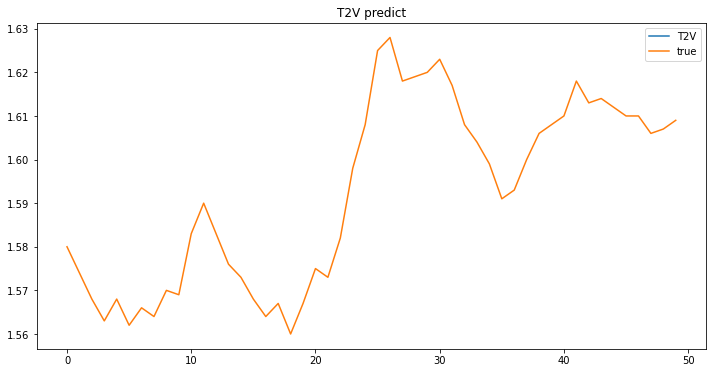

In [20]:
plt.figure(figsize=(12,6))

plt.plot(pred, label='T2V')
plt.plot(y_test.ravel(), label='true')
plt.title('T2V predict'); plt.legend()

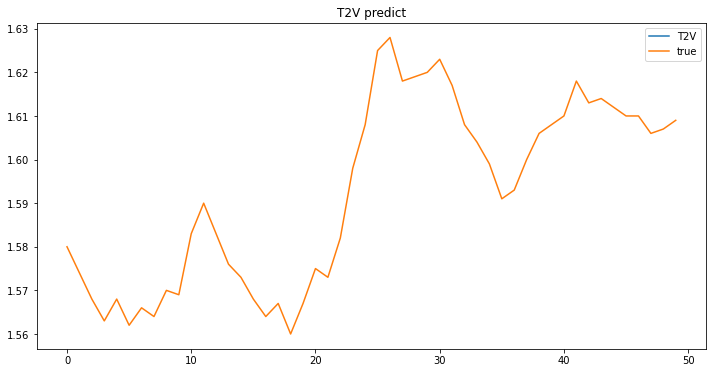

In [21]:
plt.figure(figsize=(12,6))

plt.plot(pred[:100], label='T2V')
plt.plot(y_test[:100].ravel(), label='true')
plt.title('T2V predict'); plt.legend()

In [22]:
print(mean_absolute_error(y_test.ravel(), pred))
log_metric("MAE",mean_absolute_error(y_test.ravel(), pred)) 

ValueError: ignored

In [ ]:
!mlflow ui